# Walmart Recruiting: Trip Type Classification
- Here's the decryption key: Work4WalmarT
- 마트에 오는 customer의 product code를 가지고 고객의 triptype을 예측한다
- https://www.kaggle.com/c/walmart-recruiting-trip-type-classification

---

In [56]:
import numpy as np
import pandas as pd
pd.set_option('max_rows',38)
pd.set_option('max_columns',25)
import matplotlib.pylab as plt
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from wordcloud import WordCloud, STOPWORDS
from matplotlib_venn import venn2
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.model_selection import KFold, cross_val_score
import time

# Plotting Decision tree
from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

# Data Check

#### - test.csv

In [2]:
test = pd.read_csv("./data/test.csv")
print("test data shape: "+str(test.shape))
test.tail()

test data shape: (653646, 6)


,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
653641,191348,Sunday,6.657211e+10,1,BATH AND SHOWER,1505.0
653642,191348,Sunday,8.818139e+10,1,BATH AND SHOWER,1099.0
653643,191348,Sunday,4.282557e+09,1,MENS WEAR,8220.0
653644,191348,Sunday,8.046919e+10,1,SWIMWEAR/OUTERWEAR,114.0
653645,191348,Sunday,7.871536e+09,1,MENS WEAR,4923.0


In [3]:
print('total test data VisitNumber count: '+str(len(test.VisitNumber)))
print('unique test data VisitNumber count: '+str(len(test.VisitNumber.unique())))
test.VisitNumber.unique()

total test data VisitNumber count: 653646
unique test data VisitNumber count: 95674


array([     1,      2,      3, ..., 191340, 191341, 191348])

#### - sample_submission.csv

In [4]:
samplesub = pd.read_csv("./data/sample_submission.csv")
print("sample_submission data shape: "+str(samplesub.shape))
samplesub.tail()

sample_submission data shape: (95674, 39)


,VisitNumber,TripType_3,TripType_4,TripType_5,TripType_6,TripType_7,TripType_8,TripType_9,TripType_12,TripType_14,TripType_15,TripType_18,...,TripType_34,TripType_35,TripType_36,TripType_37,TripType_38,TripType_39,TripType_40,TripType_41,TripType_42,TripType_43,TripType_44,TripType_999
95669,191338,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
95670,191339,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
95671,191340,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
95672,191341,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0
95673,191348,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0


- 각 TripType에 대한 proba를 제출해야 한다.

In [5]:
print('total test data VisitNumber count: '+str(len(samplesub.VisitNumber)))
print('unique sample_submission data VisitNumber count: '+str(len(samplesub.VisitNumber.unique())))
samplesub.VisitNumber.unique()

total test data VisitNumber count: 95674
unique sample_submission data VisitNumber count: 95674


array([     1,      2,      3, ..., 191340, 191341, 191348])

#### - train.csv

In [6]:
train = pd.read_csv("./data/train.csv")
print("train data shape: "+str(train.shape))
train.tail()

train data shape: (647054, 7)


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
647049,39,191346,Sunday,3.239000e+10,1,PHARMACY OTC,1118.0
647050,39,191346,Sunday,7.874205e+09,1,FROZEN FOODS,1752.0
647051,39,191346,Sunday,4.072000e+03,1,PRODUCE,4170.0
647052,8,191347,Sunday,4.190008e+09,1,DAIRY,1512.0
647053,8,191347,Sunday,3.800060e+09,1,GROCERY DRY GOODS,3600.0


---

# Exploratory Data Analysis (EDA)

#### - Check & Change the data dtypes

In [7]:
#before
train.dtypes

TripType                   int64
VisitNumber                int64
Weekday                   object
Upc                      float64
ScanCount                  int64
DepartmentDescription     object
FinelineNumber           float64
dtype: object

#### - Copy train -> data

In [8]:
data = train.copy()

In [9]:
# change dtypes
data['TripType'] = data['TripType'].astype('category')
data['VisitNumber'] = data['VisitNumber'].astype('category') 
data['Weekday'] = data['Weekday'].astype('category')
data['Upc'] = data['Upc'].astype('category')
data['ScanCount'] = data['ScanCount'].astype('category')
data['DepartmentDescription'] = data['DepartmentDescription'].astype('str')
data['FinelineNumber'] = data['FinelineNumber'].astype('category')

In [10]:
#after
data.dtypes

TripType                 category
VisitNumber              category
Weekday                  category
Upc                      category
ScanCount                category
DepartmentDescription      object
FinelineNumber           category
dtype: object

#### - Categorical variables describe

In [11]:
data.describe(include=["category"])

,TripType,VisitNumber,Weekday,Upc,ScanCount,FinelineNumber
count,647054,647054,647054,642925.0,647054,642925.0
unique,38,95674,7,97714.0,39,5195.0
top,40,72439,Sunday,4011.0,1,5501.0
freq,174164,209,133975,7657.0,561489,8244.0


#### - String variable describe

In [12]:
data.describe(include=["O"])

,DepartmentDescription
count,647054
unique,69
top,GROCERY DRY GOODS
freq,70402


#### - Make All variables describe DataFrame

In [13]:
desc_df = data.describe(include='all').transpose()
desc_df

,count,unique,top,freq
TripType,647054,38,40,174164
VisitNumber,647054,95674,72439,209
Weekday,647054,7,Sunday,133975
Upc,642925,97714,4011,7657
ScanCount,647054,39,1,561489
DepartmentDescription,647054,69,GROCERY DRY GOODS,70402
FinelineNumber,642925,5195,5501,8244


### Categorical variables

#### 1. TripType
- A categorical id representing the type of shopping trip the customer made.<br/>
This is the ground truth that you are predicting. TripType_999 is an "other" category.

In [14]:
print('total TripType count: '+str(len(data['TripType'])))
print('unique TripType count: '+str(len(data['TripType'].unique())))

total TripType count: 647054
unique TripType count: 38


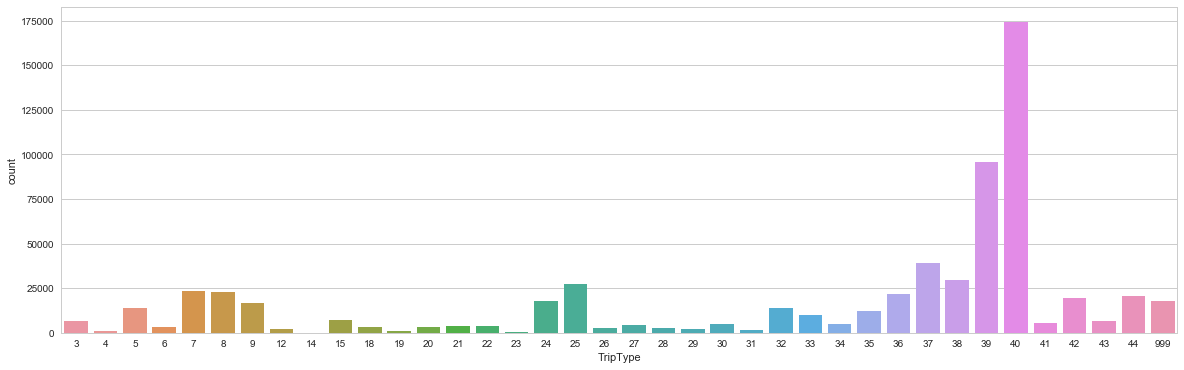

In [15]:
plt.figure(figsize=(20,6))
sns.countplot(data['TripType'])
plt.show()

#### 2. VisitNumber
- An id corresponding to a single trip by a single customer

In [16]:
print('total VisitNumber count: '+str(len(data['VisitNumber'])))
print('unique VisitNumber count: '+str(len(data['VisitNumber'].unique())))

total VisitNumber count: 647054
unique VisitNumber count: 95674


In [17]:
pd.DataFrame(data['VisitNumber'].value_counts()).transpose()

,72439,88011,9181,60971,65792,80318,178154,181457,84786,59358,179810,78556,...,115351,115343,115338,36656,115317,115313,115306,115292,115266,115246,36688,5
VisitNumber,209,151,113,112,111,104,98,97,97,96,94,94,...,1,1,1,1,1,1,1,1,1,1,1,1


⬆︎ *VisitNumber로 표현된 각 소비자가 방문한 총 횟수*

#### 3. Weekday
- The weekday of the trip

In [18]:
print('total Weekday count: '+str(len(data['Weekday'])))
print('unique Weekday count: '+str(len(data['Weekday'].unique())))

total Weekday count: 647054
unique Weekday count: 7


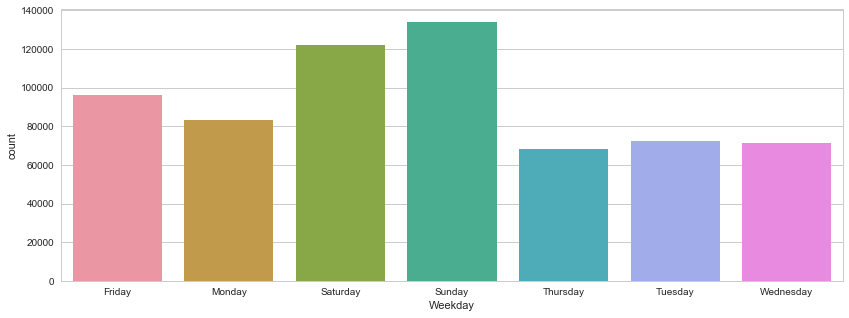

In [19]:
plt.figure(figsize=(14,5))
sns.countplot(data['Weekday'])
plt.show()

In [20]:
temp = data['Weekday'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Distribution of differnet Weekday')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

#### 4. Upc
- The UPC(Universal Product Code) number of the product purchased

In [21]:
print('total Upc count: '+str(len(data['Upc'])))
print('unique Upc count: '+str(len(data['Upc'].unique())))

total Upc count: 647054
unique Upc count: 97715


In [22]:
pd.DataFrame(data['Upc'].value_counts()).transpose()

,4011.0,60538862097.0,7874235186.0,7874235187.0,4046.0,68113107862.0,60538871457.0,3338320027.0,4087.0,60538871461.0,4900000044.0,4062.0,...,60892600460.0,60892600436.0,60872100140.0,60838315579.0,60838315445.0,60838315443.0,60786920092.0,60786920087.0,60786920069.0,60786920065.0,60786920062.0,7874222771.0
Upc,7657,2501,2067,1883,1652,1515,1487,1405,1370,1343,1018,973,...,1,1,1,1,1,1,1,1,1,1,1,1


⬆︎ *Upc에 해당하는 즉, 각 물품이 판매된 갯수*

#### 5. ScanCount
- The number of the given item that was purchased. A negative value indicates a product return.

In [23]:
print('total ScanCount count: '+str(len(data['ScanCount'])))
print('unique ScanCount count: '+str(len(data['ScanCount'].unique())))

total ScanCount count: 647054
unique ScanCount count: 39


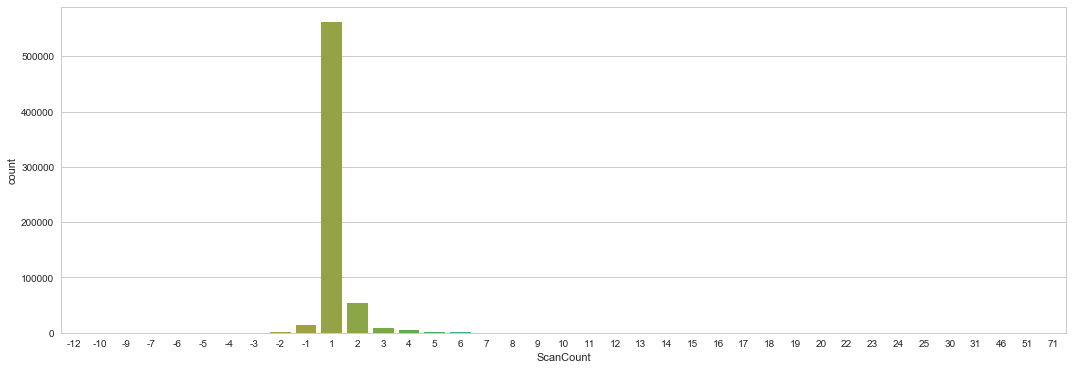

In [24]:
plt.figure(figsize=(18,6))
sns.countplot(data['ScanCount'])
plt.show()

In [25]:
temp = data['ScanCount'].value_counts()
labels = temp.index
sizes = (temp / temp.sum())*100
trace = go.Pie(labels=labels, values=sizes, hoverinfo='label+percent')
layout = go.Layout(title='Distribution of differnet ScanCount')
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

#### 6. FinelineNumber
- A more refined category for each of the products, created by Walmart

In [26]:
print('total FinelineNumber count: '+str(len(data['FinelineNumber'])))
print('unique FinelineNumber count: '+str(len(data['FinelineNumber'].unique())))

total FinelineNumber count: 647054
unique FinelineNumber count: 5196


In [27]:
pd.DataFrame(data['FinelineNumber'].value_counts()).transpose()

,5501.0,1508.0,135.0,808.0,0.0,9546.0,1407.0,4606.0,115.0,203.0,100.0,3004.0,...,4845.0,830.0,238.0,5052.0,5358.0,5171.0,5172.0,5216.0,5217.0,5218.0,5353.0,1765.0
FinelineNumber,8244,5121,4538,4401,3837,2997,2848,2753,2723,2639,2634,2607,...,1,1,1,1,1,1,1,1,1,1,1,1


⬆︎ *물품들을 FinelineNumber로 세부적으로 분류한 것에 해당하는 각 물품 종류의 판매 갯수*

### String variables

#### 1. DepartmentDescription
- A high-level description of the item's department

In [28]:
print('total DepartmentDescription count: '+str(len(data['DepartmentDescription'])))
print('unique DepartmentDescription count: '+str(len(data['DepartmentDescription'].unique())))

total DepartmentDescription count: 647054
unique DepartmentDescription count: 69


In [29]:
pd.DataFrame(data['DepartmentDescription'].value_counts()).transpose()

,GROCERY DRY GOODS,DSD GROCERY,PRODUCE,DAIRY,PERSONAL CARE,IMPULSE MERCHANDISE,HOUSEHOLD CHEMICALS/SUPP,PHARMACY OTC,FROZEN FOODS,HOUSEHOLD PAPER GOODS,COMM BREAD,BEAUTY,...,OPTICAL - FRAMES,FURNITURE,SHEER HOSIERY,1-HR PHOTO,MENSWEAR,CAMERAS AND SUPPLIES,OPTICAL - LENSES,LARGE HOUSEHOLD GOODS,CONCEPT STORES,OTHER DEPARTMENTS,SEASONAL,HEALTH AND BEAUTY AIDS
DepartmentDescription,70402,68332,51115,43820,41969,28712,24880,23306,21101,16274,15244,14865,...,579,477,434,394,338,221,85,77,35,29,29,2


⬆︎ *DepartmentDescription으로 high-level 분류된 각 물품 종류의 판매 갯수*

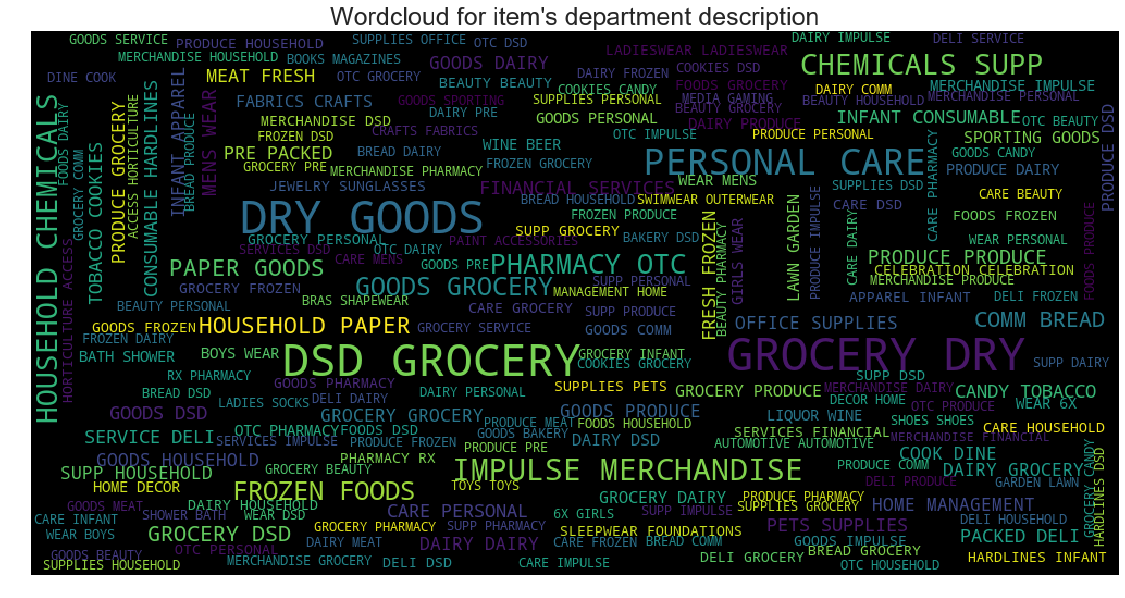

In [30]:
names = data["DepartmentDescription"][~pd.isnull(data["DepartmentDescription"])]
wordcloud = WordCloud(max_font_size=42, width=1000, height=500, font_step=1).generate(' '.join(names))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.title("Wordcloud for item's department description", fontsize=25)
plt.axis("off")
plt.show() 

### Relation between TripType and others

#### 1. TripType and VisitNumber

In [31]:
data.groupby('TripType')['VisitNumber'].value_counts().unstack().head(6)

VisitNumber,5,7,8,9,10,11,12,15,17,19,20,23,...,191324,191326,191329,191331,191335,191337,191342,191343,191344,191345,191346,191347
TripType,,,,,,,,,,,,,,,,,,,,,,,,,
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2.0


⬆︎ [TripType : VisitNumber] - [1 : N] 관계임을 알수있다. **그런데 대부분 1:1 관계임**

#### 2. TripType and Weekday

In [32]:
data.groupby('TripType')['Weekday'].value_counts().unstack().tail(10)

Weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
TripType,,,,,,,
36,3583.0,2793.0,4139.0,3807.0,2735.0,2421.0,2512.0
37,5678.0,5405.0,6774.0,9119.0,3913.0,4247.0,3818.0
38,4113.0,4322.0,4363.0,6254.0,3101.0,3862.0,3550.0
39,14551.0,12884.0,16708.0,19444.0,10549.0,11005.0,10363.0
40,23002.0,22380.0,36383.0,43024.0,14673.0,17954.0,16748.0
41,862.0,562.0,1218.0,1285.0,659.0,421.0,501.0
42,2910.0,2036.0,4033.0,4183.0,2164.0,1981.0,2161.0
43,1125.0,834.0,1216.0,1161.0,624.0,640.0,783.0
44,2902.0,2239.0,4474.0,4230.0,2150.0,1876.0,2553.0


⬆︎ 각 TripType 마다 주로 장보러가는 요일을 파악하고 싶었지만 표를 봐도 그렇고, 한 타입안에 여러명이 존재하기 때문에 그런 인사이트는 확인할 수 없을 것 같다. 

#### 3. TripType and Upc

In [33]:
data.groupby('TripType')['Upc'].value_counts().unstack().head(10)

Upc,834.0,3032.0,3035.0,3066.0,3082.0,3100.0,3107.0,3112.0,3121.0,3127.0,3141.0,3151.0,...,978163346646.0,978163450096.0,978184879995.0,978194199907.0,978276432153.0,978276432351.0,978276433023.0,978276433094.0,978968151182.0,978970627397.0,978970627937.0,978970666419.0
TripType,,,,,,,,,,,,,,,,,,,,,,,,,
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,1.0,NaN,8.0,NaN,1.0,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,29.0,NaN,22.0,1.0,1.0,NaN,NaN,75.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,3.0,NaN,6.0,1.0,20.0,2.0,NaN,1.0,NaN,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
12,NaN,NaN,1.0,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


⬆︎ 차원이 너무 커서 확인해보기 어렵지만 각 TripType 마다 주로 구매하는 Upc 종류를 발견할 수 있을지도?

#### 4. TripType and ScanCount

In [34]:
data.groupby('TripType')['ScanCount'].value_counts().unstack().tail(10)

ScanCount,-12,-10,-9,-7,-6,-5,-4,-3,-2,-1,1,2,...,18,19,20,22,23,24,25,30,31,46,51,71
TripType,,,,,,,,,,,,,,,,,,,,,,,,,
36,NaN,NaN,1.0,NaN,1.0,NaN,3.0,4.0,19.0,177.0,19793.0,1498.0,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
37,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,23.0,307.0,34782.0,3066.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,12.0,208.0,25490.0,2910.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN
39,1.0,NaN,NaN,NaN,NaN,1.0,4.0,8.0,36.0,719.0,85603.0,7134.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,NaN,NaN,NaN,NaN,NaN,NaN,6.0,14.0,66.0,1034.0,150250.0,17209.0,...,NaN,3.0,1.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,1.0,NaN
41,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,59.0,4968.0,370.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,NaN,NaN,NaN,NaN,NaN,1.0,NaN,4.0,14.0,176.0,17417.0,1413.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,53.0,5784.0,434.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,6.0,139.0,18113.0,1623.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 5. TripType and DepartmentDescription

In [35]:
data.groupby('TripType')['DepartmentDescription'].value_counts().unstack().head(6)

DepartmentDescription,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,CAMERAS AND SUPPLIES,"CANDY, TOBACCO, COOKIES",...,PRODUCE,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS,nan
TripType,,,,,,,,,,,,,,,,,,,,,,,,,
3,2.0,2.0,20.0,5.0,8.0,24.0,4.0,4.0,9.0,NaN,5.0,24.0,...,22.0,NaN,NaN,13.0,NaN,6.0,2.0,16.0,2.0,6.0,3.0,5.0
4,NaN,1.0,3.0,13.0,NaN,7.0,NaN,NaN,NaN,NaN,NaN,9.0,...,37.0,NaN,NaN,9.0,NaN,1.0,NaN,2.0,NaN,2.0,NaN,1.0
5,1.0,16.0,40.0,66.0,25.0,232.0,7.0,15.0,15.0,9.0,2.0,133.0,...,435.0,3.0,1.0,97.0,6.0,40.0,16.0,39.0,NaN,19.0,11.0,13.0
6,1.0,3.0,5.0,23.0,6.0,23.0,2.0,2.0,1.0,NaN,NaN,674.0,...,148.0,4.0,1.0,56.0,NaN,13.0,4.0,9.0,NaN,3.0,1.0,3.0
7,3.0,11.0,31.0,897.0,5.0,75.0,8.0,15.0,6.0,2.0,NaN,151.0,...,3022.0,330.0,NaN,3669.0,4.0,29.0,12.0,30.0,3.0,20.0,11.0,29.0
8,NaN,6.0,56.0,472.0,36.0,1112.0,6.0,17.0,16.0,6.0,NaN,579.0,...,1974.0,2.0,NaN,218.0,3.0,50.0,9.0,31.0,9.0,28.0,8.0,68.0


#### 6. TripType and FinelineNumber

In [36]:
data.groupby('TripType')['FinelineNumber'].value_counts().unstack().head(6)

FinelineNumber,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,...,9960.0,9961.0,9964.0,9966.0,9967.0,9970.0,9971.0,9974.0,9975.0,9991.0,9997.0,9998.0
TripType,,,,,,,,,,,,,,,,,,,,,,,,,
3,826.0,NaN,76.0,1.0,NaN,NaN,3.0,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
4,5.0,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,51.0,3.0,3.0,1.0,1.0,8.0,6.0,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,3.0
6,15.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
7,66.0,5.0,1.0,NaN,NaN,3.0,2.0,NaN,NaN,1.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
8,NaN,36.0,3.0,2.0,NaN,30.0,4.0,3.0,2.0,NaN,12.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0


### Relation between Others (except TripType)

#### - Upc & DepartmentDescription

In [37]:
data.groupby('Upc')['DepartmentDescription'].value_counts().unstack().head(6)

DepartmentDescription,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,CAMERAS AND SUPPLIES,"CANDY, TOBACCO, COOKIES",...,PRE PACKED DELI,PRODUCE,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
Upc,,,,,,,,,,,,,,,,,,,,,,,,,
834.0,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3032.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3035.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3066.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3082.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,405.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### - FinelineNumber & DepartmentDescription

In [38]:
data.groupby('FinelineNumber')['DepartmentDescription'].value_counts().unstack().head(6)

DepartmentDescription,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,BOOKS AND MAGAZINES,BOYS WEAR,BRAS & SHAPEWEAR,CAMERAS AND SUPPLIES,"CANDY, TOBACCO, COOKIES",...,PRE PACKED DELI,PRODUCE,SEAFOOD,SEASONAL,SERVICE DELI,SHEER HOSIERY,SHOES,SLEEPWEAR/FOUNDATIONS,SPORTING GOODS,SWIMWEAR/OUTERWEAR,TOYS,WIRELESS
FinelineNumber,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.0,NaN,NaN,12.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,14.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4.0,NaN,22.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
5.0,NaN,NaN,15.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0


### Check Missing Values

In [39]:
data = train.copy()
desc_df['MV_count'] = train.isnull().sum()
desc_df['MV_ratio'] = desc_df['MV_count']/train.shape[0]
desc_df

,count,unique,top,freq,MV_count,MV_ratio
TripType,647054,38,40,174164,0,0.000000
VisitNumber,647054,95674,72439,209,0,0.000000
Weekday,647054,7,Sunday,133975,0,0.000000
Upc,642925,97714,4011,7657,4129,0.006381
ScanCount,647054,39,1,561489,0,0.000000
DepartmentDescription,647054,69,GROCERY DRY GOODS,70402,1361,0.002103
FinelineNumber,642925,5195,5501,8244,4129,0.006381


In [43]:
data['Weekday'] = preprocessing.LabelEncoder().fit_transform(list(data['Weekday']))
data['Upc'].fillna(value=-1, inplace=True)
data['DepartmentDescription'] = preprocessing.LabelEncoder().fit_transform(list(data['DepartmentDescription']))
data['FinelineNumber'].fillna(value=-999, inplace=True)

In [44]:
# after NaN preprocessing
desc_df['MV_count'] = data.isnull().sum()
desc_df['MV_ratio'] = desc_df['MV_count']/data.shape[0]
desc_df

,count,unique,top,freq,MV_count,MV_ratio
TripType,647054,38,40,174164,0,0.0
VisitNumber,647054,95674,72439,209,0,0.0
Weekday,647054,7,Sunday,133975,0,0.0
Upc,642925,97714,4011,7657,0,0.0
ScanCount,647054,39,1,561489,0,0.0
DepartmentDescription,647054,69,GROCERY DRY GOODS,70402,0,0.0
FinelineNumber,642925,5195,5501,8244,0,0.0


⬆︎ Missing Value를 모두 전처리함.

##  Feature importance via Gradient Boosting model

In [52]:
X = data.drop(columns='TripType')
y = data['TripType']

In [53]:
start_time=time.time()

gb = GradientBoostingRegressor()
gb.fit(X, y)
features = data.columns.values

end_time=time.time()
print("total time in the current cell ",end_time-start_time,"s")

total time in the cuurent cell  34.27704310417175 s


In [54]:
# Scatter plot 
trace = go.Scatter(
    y = gb.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        color = gb.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features
)

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Machine Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

In [73]:
def score(depth):
    tree1 = tree.DecisionTreeRegressor\
    (max_depth=depth, random_state=0).fit(X, y)
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    return cross_val_score(tree1, X, y, cv=cv)

In [74]:
start_time=time.time()

score_list=[]
for i in range(1,16):
    score_list.append(score(i).mean())
    
end_time=time.time()
print("total time in the current cell ",end_time-start_time,"s")

total time in the cuurent cell  98.03799605369568 s


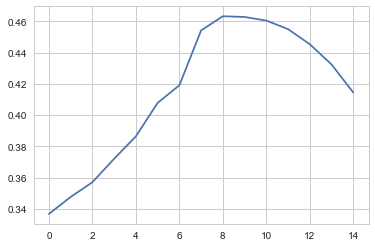

In [75]:
plt.plot(score_list)
plt.show()

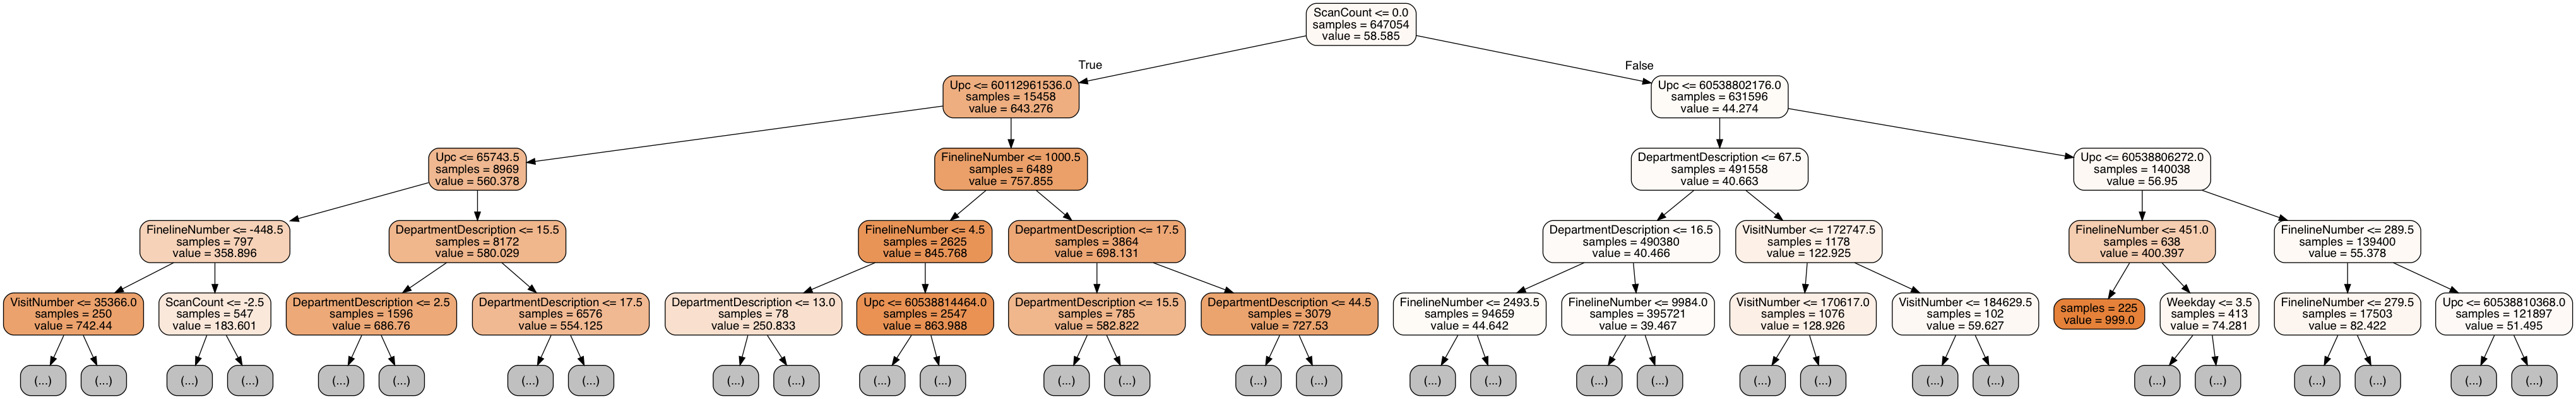

In [113]:
decision_tree = tree.DecisionTreeRegressor(max_depth = 8)
model = decision_tree.fit(X, y)

# Export our trained model as a .dot file
with open("tree.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 4,
                              impurity = False,
                              feature_names = X.columns.values,
                              class_names = ['No', 'Yes'],
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree.dot','-o','tree.png'])

# Annotating chart with PIL
img = Image.open("tree.png")
draw = ImageDraw.Draw(img)
# img.save('sample-out.png')
PImage("tree.png",)

In [81]:
test_data = test.copy()

In [83]:
test_data['Weekday'] = preprocessing.LabelEncoder().fit_transform(list(test_data['Weekday']))
test_data['Upc'].fillna(value=-1, inplace=True)
test_data['DepartmentDescription'] = preprocessing.LabelEncoder().fit_transform(list(test_data['DepartmentDescription']))
test_data['FinelineNumber'].fillna(value=-999, inplace=True)

In [85]:
test_data.tail()

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
653641,191348,3,6.657211e+10,1,4,1505.0
653642,191348,3,8.818139e+10,1,4,1099.0
653643,191348,3,4.282557e+09,1,42,8220.0
653644,191348,3,8.046919e+10,1,64,114.0
653645,191348,3,7.871536e+09,1,42,4923.0


In [117]:
result = model.predict(test_data)

In [118]:
result

array([ 45.32607739,  55.717234  ,  45.32607739, ...,  39.84065152,
       403.82407407,  39.84065152])